# Salt segmentation

Welcome to the first **KAUST Hackathon in Geoscience**. In this second lab, we will implement a Convolutional Neural Network that can segment seismic data and extract salt bodies. For this example we will use the openly available dataset from the [TGS Kaggle Competition](https://www.kaggle.com/c/tgs-salt-identification-challenge).

More specifically, this notebook is organized as follows:

- Load dataset from a collection of .png images as provided in the Kaggle competition. For this we will rely on the `Dataset` module in Torch
- Perform a number of data augumentation stategies such as De-meaning or Polarity flipping
- Train a UNet to segment the images in binary masks (0: no salt, 1: salt)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision 

from scipy.signal import filtfilt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from skimage import io
from tqdm.notebook import tqdm

from torch.utils.data import TensorDataset, DataLoader, Dataset, ConcatDataset
from torchvision.utils import make_grid
from torchvision import transforms
from torchsummary import summary

In [2]:
def set_seed(seed):
    """Set all random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled   = False

    return True

In [3]:
def show_tensor_images(image_tensor, ax, num_images=15, vmin=-1, vmax=1, cbar=False):
    """Visualizing images

    Given a tensor of images, number of images, an size per image,
    plots and prints the images in an uniform grid.
    """
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5, normalize=False)
    ax.axis('off')
    im = ax.imshow(image_grid[0].squeeze(), cmap='gray', vmin=vmin, vmax=vmax)
    if cbar:
        plt.colorbar(im, ax=ax)

Let's begin by checking we have access to a GPU and tell Torch we would like to use it:

In [4]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = torch.device(torch.cuda.current_device())
    print(f'Device: {device} {torch.cuda.get_device_name(device)}')
else:
    print("No GPU available!")

No GPU available!


## Data loading

Let's start by loading the dataset, which is composed by pairs of images and masks. We are going to define a custom `Dataset` (see https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) as well as apply some transformations (see https://pytorch.org/vision/stable/transforms.html).

In [5]:
class SaltDataset(Dataset):
    def __init__(self, imagedir, maskdir, files, transform=None, transformmask=None):
        self.imagedir = imagedir
        self.maskdir = maskdir
        self.transform = transform
        self.transformmask = transformmask
        self.total_imgs = files

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.imagedir, self.total_imgs[idx])
        mask_loc = os.path.join(self.maskdir, self.total_imgs[idx])
        image = io.imread(img_loc, as_gray=True).squeeze().astype(np.float32)
        mask = io.imread(mask_loc, as_gray=True).astype(np.float32).squeeze() / 65535.
        sample = {'image': image, 'mask': mask}
        
        if self.transform:
            sample['image'] = self.transform(sample['image'])
            sample['mask'] = self.transformmask(sample['mask'])
        return sample

In [6]:
class DeMean(object):
    """Center mean around 0 and entire range between -1 and 1
    """
    def __init__(self):
        pass

    def __call__(self, image):
        image_mean = image.mean()
        image -= image_mean
        image_max = torch.abs(image).max()
        if image_max != 0:
            image = image / image_max
        return image
    
class Binarize(object):
    """Binarize mask (0 or 1)
    """
    def __init__(self):
        pass

    def __call__(self, image):
        image[image>0.5] = 1.
        image[image<=0.5] = 0.
        return image

In [ ]:
# Define paths for folders containing images and masks

## IF WORKING LOCALLY!! ##
datapath = 'dataset'

## IF WORKING WITH COLAB!! ##
#from google.colab import drive
#drive.mount('/content/gdrive')
#datapath = '/content/gdrive/MyDrive/KAUSTMLHack/dataset/'

In [7]:
nimages = 200 # keep low (change to -1 to use all data)
validperc = 0.2 # percentage of validation samples

traindatapath = os.path.join(datapath, 'train', 'images')
trainmaskpath = os.path.join(datapath, 'train', 'masks')
trainfiles = os.listdir(traindatapath)[:nimages]
nimages = len(trainfiles)

validfiles = trainfiles[int((1-validperc) * nimages):]
trainfiles = trainfiles[:int((1-validperc) * nimages)]

# Define data loading strategy for images
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((128, 128)),
                                DeMean()
                               ])

# Define data loading strategy for masks
transformmask = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((128, 128)),
                                    Binarize()
                                   ])

# Create Train Dataset
train_dataset = SaltDataset(traindatapath, trainmaskpath, trainfiles, 
                            transform=transform, transformmask=transformmask)
print('Training samples:', len(train_dataset))

# Create Test Dataset
valid_dataset = SaltDataset(traindatapath, trainmaskpath, validfiles, 
                            transform=transform, transformmask=transformmask)
print('Validation samples:', len(valid_dataset))

Training samples: 160
Validation samples: 40


## Data augumentation

We can also try to augument our dataset. One simple idea is to just flip the images horizontally and concatenate the two datasets

In [8]:
augument = False
if augument:
    transformaugment = transforms.Compose([transforms.ToTensor(), 
                                           transforms.Resize((128, 128)),
                                           DeMean(),
                                           transforms.RandomHorizontalFlip(p=1)
                                           ])
    transformmaskaugument = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize((128, 128)),
                                                Binarize(),
                                                transforms.RandomHorizontalFlip(p=1)
                                               ])
    train_dataset = \
        ConcatDataset([SaltDataset(traindatapath, trainmaskpath, trainfiles, transform=transform, transformmask=transformmask),
                       SaltDataset(traindatapath, trainmaskpath, trainfiles, transform=transformaugment, transformmask=transformmaskaugument)])
    print('Training samples:', len(train_dataset))

    valid_dataset = \
        ConcatDataset([SaltDataset(traindatapath, trainmaskpath, validfiles, transform=transform, transformmask=transformmask),
                       SaltDataset(traindatapath, trainmaskpath, validfiles, transform=transformaugment, transformmask=transformmaskaugument)])
    print('Validation samples:', len(valid_dataset))

## Visualize dataset

We are now ready to visualize out dataset

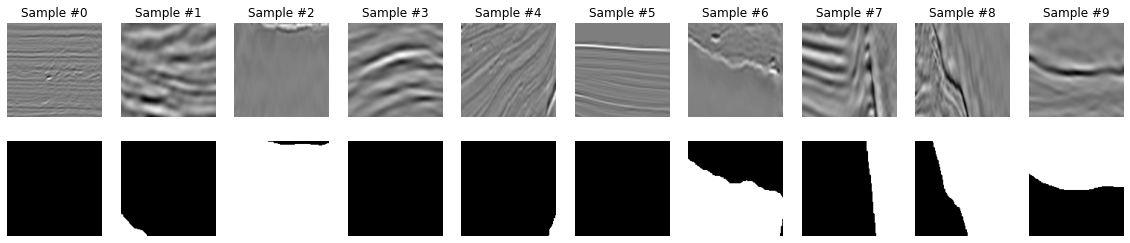

In [9]:
ncols = 10

fig, axs = plt.subplots(2, ncols, figsize=(20, 4))
for i in range(ncols):
    image, mask = train_dataset[i]['image'][0], train_dataset[i]['mask'][0]
    axs[0, i].imshow(image, cmap='gray', vmin=-1, vmax=1)
    axs[0, i].set_title('Sample #{}'.format(i))
    axs[0, i].axis('off')
    axs[1, i].imshow(mask, cmap='gray')
    axs[1, i].axis('off')

if augument:
    # Horizonally flipped data
    fig, axs = plt.subplots(2, ncols, figsize=(20, 4))
    for i in range(ncols):
        image, mask = train_dataset[len(train_dataset)//2+i]['image'][0], train_dataset[len(train_dataset)//2+i]['mask'][0]
        axs[0, i].imshow(image, cmap='gray', vmin=-1, vmax=1)
        axs[0, i].set_title('Sample #{}'.format(i))
        axs[0, i].axis('off')
        axs[1, i].imshow(mask, cmap='gray')
        axs[1, i].axis('off')

We can immediately see some problems with the masks provided in the TGS dataset. For example for sample 5, it is not obvious to see the correct shape of the salt body in the mask. Let's keep this in mind, we will come back to it later in the notebook.

We can now create our dataloaders.

In [10]:
batch_size=64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) 
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False) 

Finally we want to find out the percentage of non-salt vs. salt pixels so that we can weight this in the loss function

In [11]:
npixels = 0
npos = 0
for dl in tqdm(train_loader):
    y = dl['mask']
    npixels += len(y.view(-1))
    npos += int(y.view(-1).sum())
scaling = np.round((npixels-npos)/npos)
print(scaling)

  0%|          | 0/3 [00:00<?, ?it/s]

3.0


Using this number we can define a baseline accuracy in the case we always predict 1 or 0 to see if by training a network we can indeed do better than just guessing always one of the solutions

In [12]:
accuracy_neg = scaling/(scaling+1)
accuracy_pos = 1/(scaling+1)

print('Accuracy allneg', accuracy_neg)
print('Accuracy allpos', accuracy_pos)

Accuracy allneg 0.75
Accuracy allpos 0.25


We need at least to produce better scores that 0.75, otherwise we are just doing worse than saying there is no salt whatsoever!

## UNet Architecture

We are now ready to create our UNet Architecture. This code is highly inspired from the [Coursera GAN Specialization](https://www.coursera.org/specializations/generative-adversarial-networks-gans?utm_source=gg&utm_medium=sem&utm_content=01-CatalogDSA-ML1-US&campaignid=12490862811&adgroupid=119269357576&device=c&keyword=&matchtype=b&network=g&devicemodel=&adpostion=&creativeid=503940597773&hide_mobile_promo&gclid=EAIaIQobChMIlMrejc668gIVjtd3Ch3GPwOMEAAYASAAEgJYyvD_BwE) UNet tutorial. 

We apply some modifications, especially to allow choosing the depth of the contracting and expanding paths.

![UNET](unet.png)

In [13]:
class ContractingBlock(nn.Module):
    """Contracting block
    
    Single block in contracting path composed of two convolutions followed by a max pool operation. 
    We allow also to optionally include a batch normalization and dropout step.
    """
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels*2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(input_channels*2, input_channels*2, kernel_size=3, padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels * 2, momentum=0.8)
        self.use_bn = use_bn
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x

    
class ExpandingBlock(nn.Module):
    """Expanding block
    
    Single block in expanding path composed of an upsampling layer, a convolution, a concatenation of 
    its output with the features at the same level in the contracting path, two additional convolutions.    
    We allow also to optionally include a batch normalization and dropout step.
    """
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(input_channels // 2, input_channels // 2, kernel_size=3, padding=1)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels // 2, momentum=0.8)
        self.use_bn = use_bn
        self.activation = nn.ReLU()
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x, skip_con_x):
        x = self.upsample(x)
        x = self.conv1(x)
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv3(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        return x


class FeatureMapBlock(nn.Module):
    """Feature Map block
    
    Final layer of U-Net which restores for the output channel dimensions to those of the input (or any other size) 
    using a 1x1 convolution.
    """
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)

    def forward(self, x):
        x = self.conv(x)
        return x

    
class UNet(nn.Module):
    """UNet architecture
    
    UNet architecture composed of a series of contracting blocks followed by expanding blocks. 
    
    Most UNet implementations available online hard-code a certain number of levels. Here,
    the number of levels for the contracting and expanding paths can be defined by the user and the 
    UNet is built in such a way that the same code can be used for any number of levels without modification.
    """
    def __init__(self, input_channels=1, output_channels=1, hidden_channels=64, levels=2):
        super(UNet, self).__init__()
        self.levels = levels
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract = []
        self.expand = []
        for level in range(levels):
            self.contract.append(ContractingBlock(hidden_channels * (2**level), use_dropout=False))
        for level in range(levels):
            self.expand.append(ExpandingBlock(hidden_channels * (2**(levels-level))))
        self.contracts = nn.Sequential(*self.contract)  
        self.expands = nn.Sequential(*self.expand)  
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)

    def forward(self, x):
        xenc = []
        x = self.upfeature(x)
        xenc.append(x)
        for level in range(self.levels):
            x = self.contract[level](x)
            xenc.append(x)
        for level in range(self.levels):
            x = self.expand[level](x,xenc[self.levels-level-1])
        xn = self.downfeature(x)
        return xn

In [14]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [15]:
set_seed(42)
network = UNet(1, 1, hidden_channels=16).to(device)
#network = network.apply(weights_init) 
print(network)
summary(network, input_size=(1, 128, 128))

UNet(
  (upfeature): FeatureMapBlock(
    (conv): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
  )
  (contracts): Sequential(
    (0): ContractingBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    )
    (1): ContractingBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    

**Exercise**: You can see that we have so far commented out the initialization of weights, meaning we use the default initialization in PyTorch. Try playing with different iniliazation strategies and see how that affects the result. Remember our previous lab when we used the W&B tool, do not start doing wild experimentation without tracking your results, leverage this tool when it makes sense!

## Training

In [16]:
def train(model, criterion, optimizer, data_loader, plotflag=False):
    model.train()
    accuracy = 0
    loss = 0
    for dl in tqdm(data_loader):
        X, y = dl['image'], dl['mask']
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        yprob = model(X)
        ls = criterion(yprob.view(-1), y.view(-1))
        ls.backward()
        optimizer.step()
        with torch.no_grad():
            yprob = nn.Sigmoid()(yprob)
            ypred = (yprob.detach().cpu().numpy() > 0.5).astype(float)
        loss += ls.item()
        accuracy += accuracy_score(y.cpu().numpy().ravel(), ypred.ravel())
    loss /= len(data_loader)
    accuracy /= len(data_loader)
    
    if plotflag:
        fig, axs = plt.subplots(2, 2, figsize=(16, 9))
        plt.suptitle('Training')
        show_tensor_images(X, ax=axs[0][0], num_images=15, vmin=-1, vmax=1)
        axs[0][0].set_title("Images")
        axs[0][0].axis('tight')
        show_tensor_images(y, ax=axs[0][1], num_images=15, vmin=0, vmax=1)
        axs[0][1].set_title("Mask")
        axs[0][1].axis('tight')
        show_tensor_images(yprob, ax=axs[1][0], num_images=15, vmin=0, vmax=1)
        axs[1][0].set_title("Reconstructed Mask (Prob.)")
        axs[1][0].axis('tight')
        show_tensor_images(torch.from_numpy(ypred), ax=axs[1][1], num_images=15, vmin=0, vmax=1)
        axs[1][1].set_title("Reconstructed Mask")
        axs[1][1].axis('tight')
        plt.show()    
    return loss, accuracy


def evaluate(model, criterion, data_loader, plotflag=False):
    #model.eval()
    model.train()
    accuracy = 0
    loss = 0
    for dl in data_loader:
        X, y = dl['image'], dl['mask']
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            yprob = model(X)
            ls = criterion(yprob.view(-1), y.view(-1))
            yprob = nn.Sigmoid()(yprob)
            ypred = (yprob.detach().cpu().numpy() > 0.5).astype(float)
        loss += ls.item()
        accuracy += accuracy_score(y.cpu().numpy().ravel(), ypred.ravel())
    loss /= len(data_loader)
    accuracy /= len(data_loader)
    
    if plotflag:
        fig, axs = plt.subplots(2, 2, figsize=(16, 9))
        plt.suptitle('Validation')
        show_tensor_images(X, ax=axs[0][0], num_images=15, vmin=-1, vmax=1)
        axs[0][0].set_title("Images")
        axs[0][0].axis('tight')
        show_tensor_images(y, ax=axs[0][1], num_images=15, vmin=0, vmax=1)
        axs[0][1].set_title("Mask")
        axs[0][1].axis('tight')
        show_tensor_images(yprob, ax=axs[1][0], num_images=15, vmin=0, vmax=1)
        axs[1][0].set_title("Reconstructed Mask (Prob.)")
        axs[1][0].axis('tight')
        show_tensor_images(torch.from_numpy(ypred), ax=axs[1][1], num_images=15, vmin=0, vmax=1)
        axs[1][1].set_title("Reconstructed Mask")
        axs[1][1].axis('tight')
        plt.show()    
    return loss, accuracy

Let's train!!

  0%|          | 0/3 [00:00<?, ?it/s]

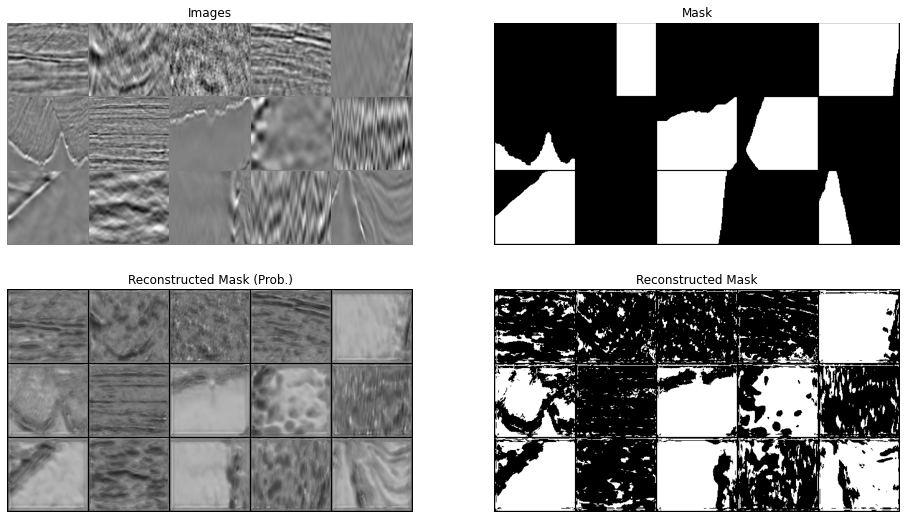

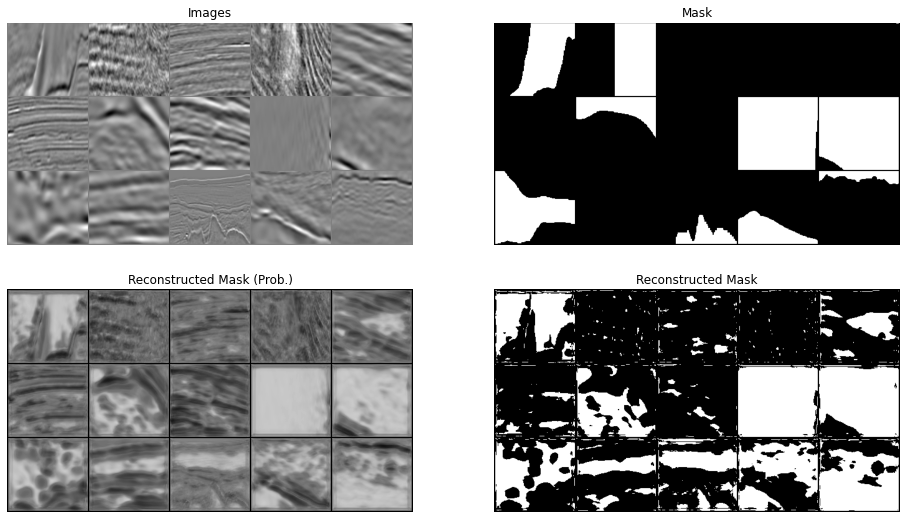

Epoch 0, Training Loss 0.67, Training Accuracy 0.60, Test Loss 0.65, Test Accuracy 0.69


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, Training Loss 0.58, Training Accuracy 0.77, Test Loss 0.57, Test Accuracy 0.76


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2, Training Loss 0.53, Training Accuracy 0.82, Test Loss 0.59, Test Accuracy 0.77


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3, Training Loss 0.51, Training Accuracy 0.83, Test Loss 0.53, Test Accuracy 0.78


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4, Training Loss 0.49, Training Accuracy 0.84, Test Loss 0.53, Test Accuracy 0.78


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5, Training Loss 0.47, Training Accuracy 0.85, Test Loss 0.50, Test Accuracy 0.79


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6, Training Loss 0.46, Training Accuracy 0.85, Test Loss 0.50, Test Accuracy 0.79


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7, Training Loss 0.45, Training Accuracy 0.87, Test Loss 0.51, Test Accuracy 0.79


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8, Training Loss 0.45, Training Accuracy 0.86, Test Loss 0.47, Test Accuracy 0.80


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9, Training Loss 0.44, Training Accuracy 0.86, Test Loss 0.50, Test Accuracy 0.79


  0%|          | 0/3 [00:00<?, ?it/s]

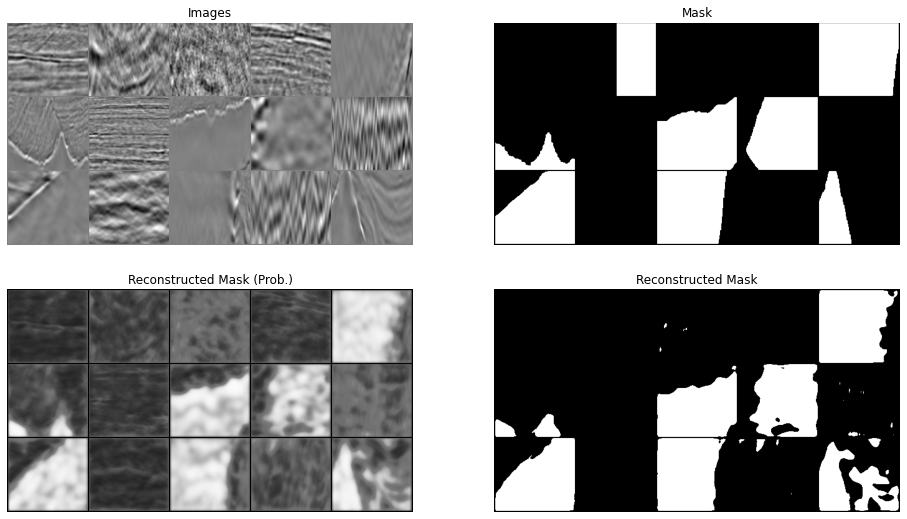

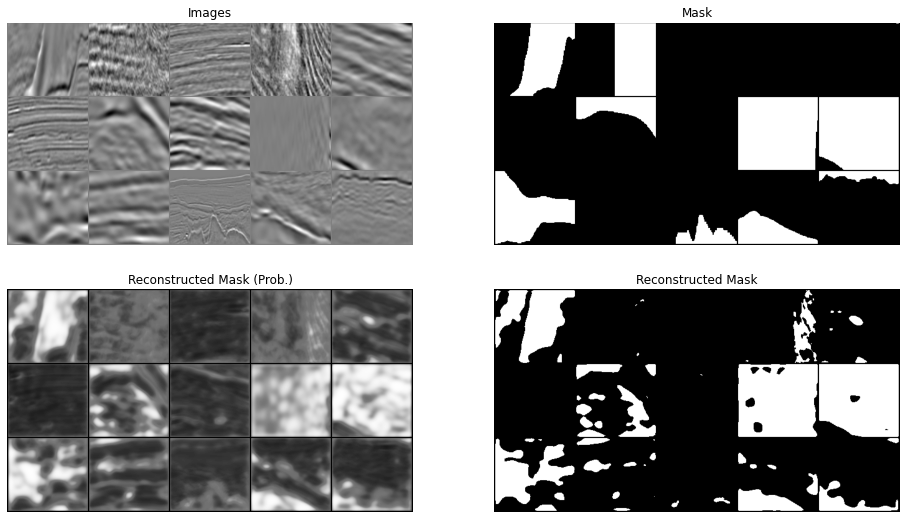

Epoch 10, Training Loss 0.43, Training Accuracy 0.86, Test Loss 0.44, Test Accuracy 0.86


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11, Training Loss 0.42, Training Accuracy 0.87, Test Loss 0.49, Test Accuracy 0.79


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12, Training Loss 0.43, Training Accuracy 0.86, Test Loss 0.44, Test Accuracy 0.80


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13, Training Loss 0.41, Training Accuracy 0.88, Test Loss 0.44, Test Accuracy 0.80


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14, Training Loss 0.41, Training Accuracy 0.86, Test Loss 0.43, Test Accuracy 0.80


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15, Training Loss 0.39, Training Accuracy 0.89, Test Loss 0.41, Test Accuracy 0.81


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16, Training Loss 0.39, Training Accuracy 0.89, Test Loss 0.43, Test Accuracy 0.81


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17, Training Loss 0.38, Training Accuracy 0.89, Test Loss 0.40, Test Accuracy 0.88


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18, Training Loss 0.37, Training Accuracy 0.88, Test Loss 0.40, Test Accuracy 0.87


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19, Training Loss 0.37, Training Accuracy 0.89, Test Loss 0.47, Test Accuracy 0.79


  0%|          | 0/3 [00:00<?, ?it/s]

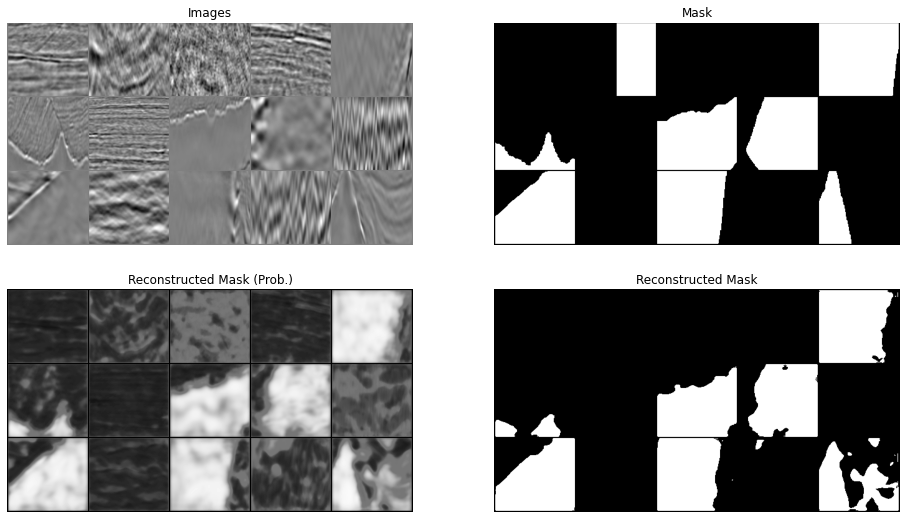

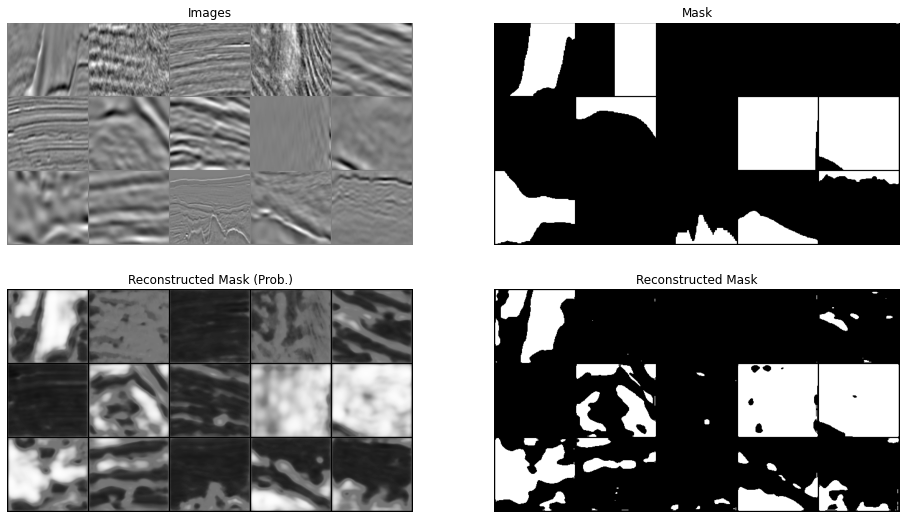

Epoch 20, Training Loss 0.38, Training Accuracy 0.88, Test Loss 0.40, Test Accuracy 0.87


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21, Training Loss 0.37, Training Accuracy 0.89, Test Loss 0.41, Test Accuracy 0.81


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22, Training Loss 0.36, Training Accuracy 0.88, Test Loss 0.37, Test Accuracy 0.87


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23, Training Loss 0.35, Training Accuracy 0.89, Test Loss 0.44, Test Accuracy 0.80


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24, Training Loss 0.35, Training Accuracy 0.89, Test Loss 0.36, Test Accuracy 0.88


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25, Training Loss 0.34, Training Accuracy 0.89, Test Loss 0.47, Test Accuracy 0.80


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26, Training Loss 0.36, Training Accuracy 0.88, Test Loss 0.37, Test Accuracy 0.87


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27, Training Loss 0.34, Training Accuracy 0.89, Test Loss 0.39, Test Accuracy 0.81


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28, Training Loss 0.34, Training Accuracy 0.88, Test Loss 0.38, Test Accuracy 0.85


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29, Training Loss 0.33, Training Accuracy 0.90, Test Loss 0.36, Test Accuracy 0.88


In [17]:
n_epochs = 30
lr = 0.001

criterion = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(network.parameters(), lr=lr)

train_loss_history = np.zeros(n_epochs)
train_accuracy_history = np.zeros(n_epochs)
test_loss_history = np.zeros(n_epochs)
test_accuracy_history = np.zeros(n_epochs)

for i in range(n_epochs):
    train_loss, train_accuracy = train(network, criterion, optim, train_loader, plotflag=True if i%10==0 else False)
    test_loss, test_accuracy = evaluate(network, criterion, valid_loader, plotflag=True if i%10==0 else False)
    train_loss_history[i], train_accuracy_history[i] = train_loss, train_accuracy
    test_loss_history[i], test_accuracy_history[i] = test_loss, test_accuracy
    print(f'Epoch {i}, Training Loss {train_loss:.2f}, Training Accuracy {train_accuracy:.2f}, Test Loss {test_loss:.2f}, Test Accuracy {test_accuracy:.2f}')

Valid Accuracy (best) 0.8792144775390625


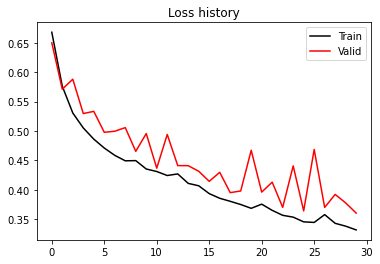

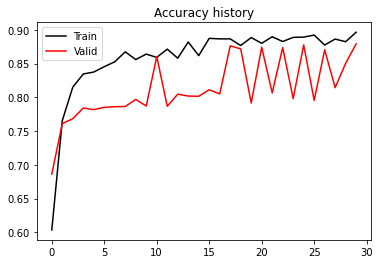

In [18]:
plt.figure()
plt.plot(train_loss_history, 'k', label='Train')
plt.plot(test_loss_history, 'r', label='Valid')
plt.title('Loss history')
plt.legend()

plt.figure()
plt.plot(train_accuracy_history, 'k', label='Train')
plt.plot(test_accuracy_history, 'r', label='Valid')
plt.title('Accuracy history')
plt.legend();

print('Valid Accuracy (best)', test_accuracy_history.max())

## Prediction

In [19]:
def predict(model, X, y, device='cpu'):
    model.train() # not eval because https://github.com/facebookresearch/SparseConvNet/issues/166
    X, y = X.to(device), y.to(device)
    # create statistics (https://discuss.pytorch.org/t/model-eval-gives-incorrect-loss-for-model-with-batchnorm-layers/7561/2)
    #network(X)
    #model.eval()
    yprob = network(X)
    with torch.no_grad():
        yprob = nn.Sigmoid()(yprob)
        y_pred = (yprob.detach().cpu().numpy() > 0.5).astype(float)
    
    fig, axs = plt.subplots(2, 2, figsize=(16, 9))
    show_tensor_images(X, ax=axs[0][0], num_images=15, vmin=-1, vmax=1, cbar=False)
    axs[0][0].set_title("Images")
    axs[0][0].axis('tight')
    show_tensor_images(y, ax=axs[0][1], num_images=15, vmin=0, vmax=1, cbar=False)
    axs[0][1].set_title("Mask")
    axs[0][1].axis('tight')
    show_tensor_images(yprob, ax=axs[1][0], num_images=15, vmin=0, vmax=1, cbar=False)
    axs[1][0].set_title("Reconstructed Mask (Prob.)")
    axs[1][0].axis('tight')
    show_tensor_images(torch.from_numpy(y_pred), ax=axs[1][1], num_images=15, vmin=0, vmax=1, cbar=False)
    axs[1][1].set_title("Reconstructed Mask")
    axs[1][1].axis('tight')
    plt.tight_layout()

Let's now display our predictions for a couple of batches

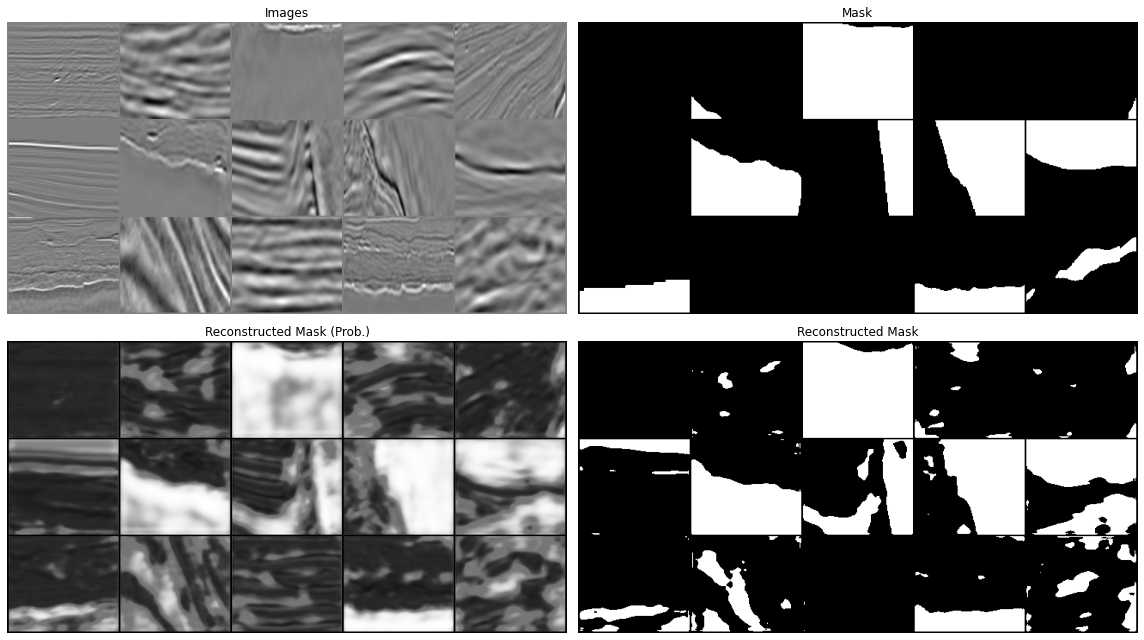

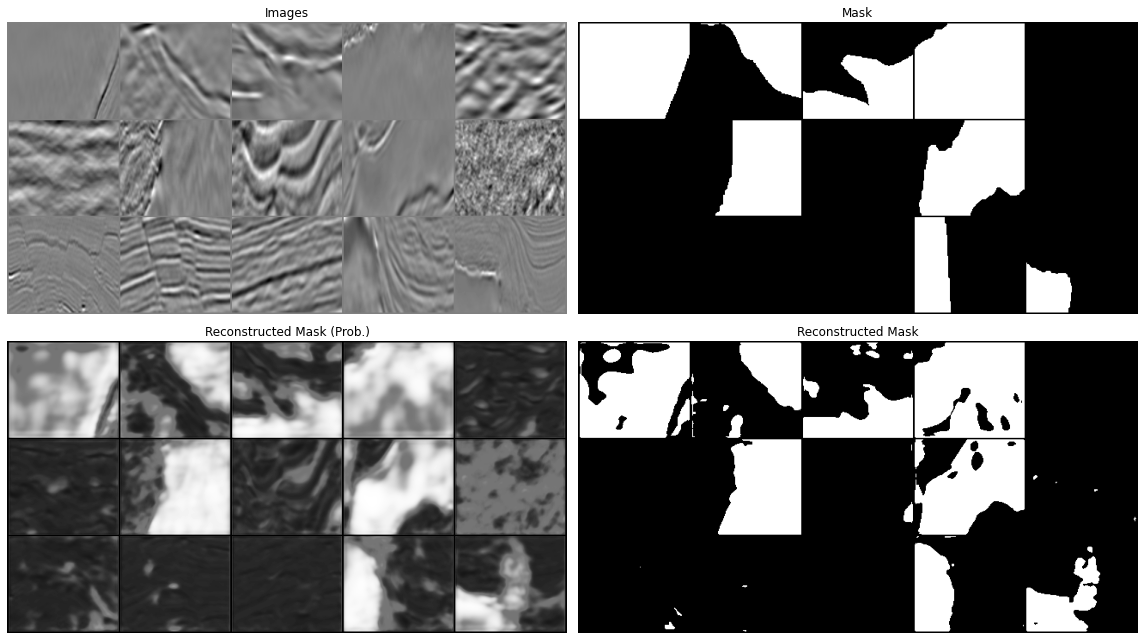

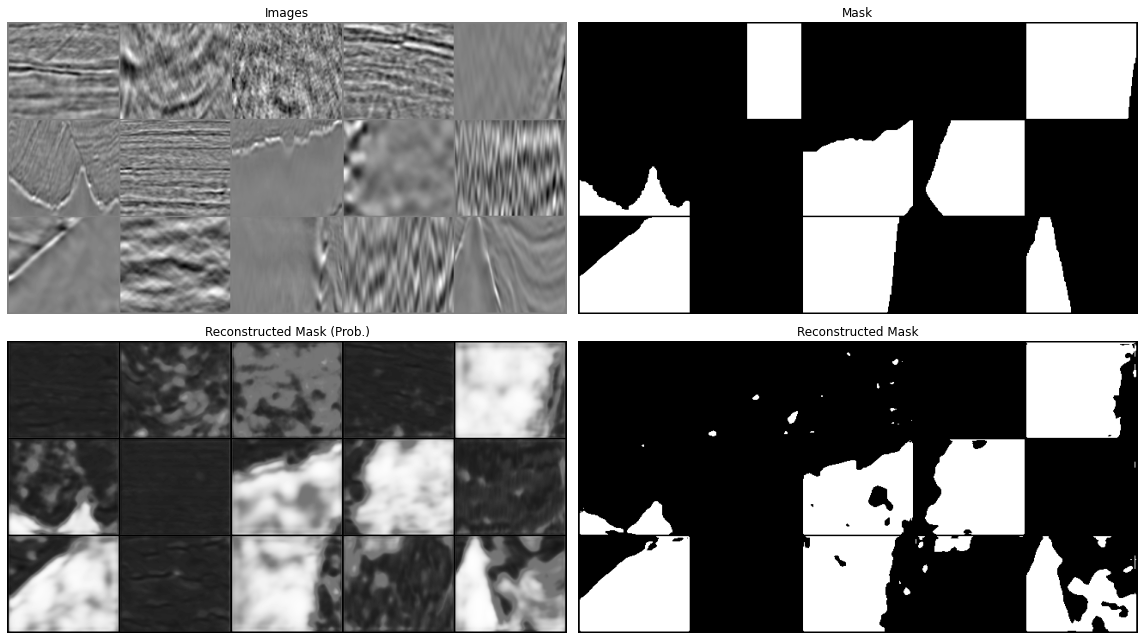

In [20]:
# dl = next(iter(train_loader)) # nextbatch 
i = 0
for dl in train_loader:
    predict(network,  dl['image'], dl['mask'], device=device)
    i+=1
    if i == 4:
        break